In [ ]:
!pip install burr[start]

In [26]:
from typing import List, Optional, Tuple

import burr.core
from burr.core import Result, State, default, expr
from burr.core.action import action
from burr.core.persistence import SQLLitePersister
from burr.lifecycle import LifecycleAdapter


In [27]:
@action(reads=["counter"], writes=["counter"])
def counter(state: State) -> Tuple[dict, State]:
    result = {"counter": state["counter"] + 1}
    print(f"counted to {result['counter']}")
    return result, state.update(**result)


# some configuration
count_up_to: int = 10
partition_key: str = "demo-user"
app_id: Optional[str] = "some-unique-id"
storage_dir: Optional[str] = "."
hooks: Optional[List[LifecycleAdapter]] = None
# set up a persister -- if you rerun this script, it will resume from where it left off.
# change the app_id to start from scratch
persister = SQLLitePersister("demos.db", "counter")
persister.initialize()

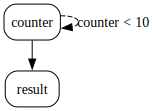

In [28]:
app = (
    burr.core.ApplicationBuilder()
    .with_actions(counter=counter, result=Result("counter"))
    .with_transitions(
        ("counter", "counter", expr(f"counter < {count_up_to}")),
        ("counter", "result", default),
    )
    .with_identifiers(partition_key=partition_key, app_id=app_id)
    .initialize_from(
        persister,
        resume_at_next_action=True,
        default_state={"counter": 0},
        default_entrypoint="counter",
    )
    .with_state_persister(persister)
    .with_tracker(project="demo_counter", params={"storage_dir": storage_dir})
    .with_hooks(*hooks if hooks else [])
    .build()
)
app.visualize(include_conditions=True)

In [29]:
action_obj, result, state = app.run(halt_after=["result"])
print(state["counter"])

counted to 1
counted to 2
counted to 3
counted to 4
counted to 5
counted to 6
counted to 7
counted to 8
counted to 9
counted to 10
10


In [30]:
app.state.get_all()

{'counter': 10, '__SEQUENCE_ID': 10, '__PRIOR_STEP': 'result'}